Data Imports

In [108]:
from libs import data
import numpy as np
import matplotlib.pyplot as plt
import math

Use the user-defined get_data function to acquire data from the quandl API. 

In [109]:
df = data.get_data("ENPH")
df.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2018-03-27,4.97,5.58,4.950,5.08,4005636.0,0.0,1.0,4.97,5.58,4.950,5.08,4005636.0
1,2018-03-26,4.95,4.97,4.620,4.92,1891721.0,0.0,1.0,4.95,4.97,4.620,4.92,1891721.0
2,2018-03-23,4.77,4.97,4.660,4.83,1296522.0,0.0,1.0,4.77,4.97,4.660,4.83,1296522.0
3,2018-03-22,4.69,4.90,4.511,4.73,1949048.0,0.0,1.0,4.69,4.90,4.511,4.73,1949048.0
4,2018-03-21,4.80,4.90,4.520,4.71,2366592.0,0.0,1.0,4.80,4.90,4.520,4.71,2366592.0


The Date column is currently a string data-type, so we need to tansform it into a datetime using the .astype() function.

In [110]:
df['Date'] = df['Date'].astype('datetime64[ns]')

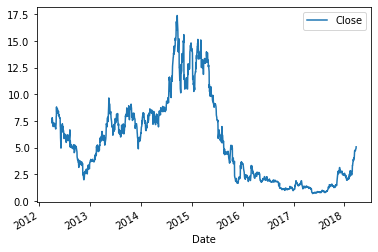

In [111]:
h=df.plot('Date', 'Close')

The closing data is nice, but seems to be quite volatile:

In [112]:
df['Close'].describe()

count    1506.000000
mean        5.489502
std         3.937394
min         0.699000
25%         1.960000
50%         4.900000
75%         7.990000
max        17.390000
Name: Close, dtype: float64

The Std Seems a bit high for me, so I'll truncate my dataset to only grab the 600 most recent prices.

In [113]:
train_data = df.iloc[:600]
train_data.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2018-03-27,4.97,5.58,4.950,5.08,4005636.0,0.0,1.0,4.97,5.58,4.950,5.08,4005636.0
1,2018-03-26,4.95,4.97,4.620,4.92,1891721.0,0.0,1.0,4.95,4.97,4.620,4.92,1891721.0
2,2018-03-23,4.77,4.97,4.660,4.83,1296522.0,0.0,1.0,4.77,4.97,4.660,4.83,1296522.0
3,2018-03-22,4.69,4.90,4.511,4.73,1949048.0,0.0,1.0,4.69,4.90,4.511,4.73,1949048.0
4,2018-03-21,4.80,4.90,4.520,4.71,2366592.0,0.0,1.0,4.80,4.90,4.520,4.71,2366592.0


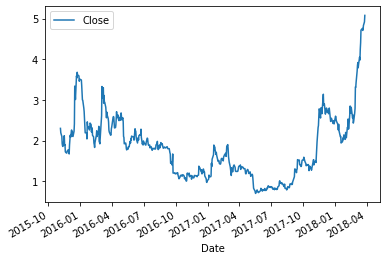

In [114]:
train_data.plot('Date','Close')

In [115]:
train_data['Close'].describe()

count    600.000000
mean       1.821183
std        0.795650
min        0.699000
25%        1.200000
50%        1.790000
75%        2.282500
max        5.080000
Name: Close, dtype: float64

That is a _much_ tighter standard deviation, so we'll go with this for our model.

Below we begin setting up the model:

In [116]:
trading_days = 30 # number of trading days to predict with
starting_value=train_data['Close'][599] # first value in the array we will fill

In [117]:
close_stats = train_data['Close'].describe()#handle for the statistics of the closing data

mu = close_stats['mean'] # average for the sample we are using
vol = close_stats['std']*math.sqrt(trading_days) # volatility of the stock over the period

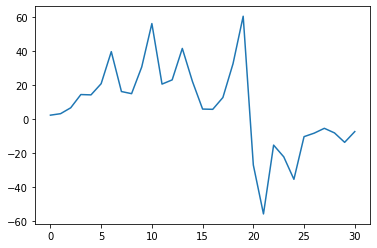

-7.339535760851029


In [119]:
daily_closes = np.random.normal((mu/trading_days), vol/math.sqrt(trading_days),trading_days)+1
# daily_closes is an array of values taken from a normal distribution based around the mean of the
# train_data, and a standard deviation based on the volatility

# the plus one is so that we can multiply the previous values in the following section by the next closing scaler

price_list=[starting_value]

for scalar in daily_closes:
    price_list.append(price_list[-1]*scalar)
#in english, each value in the price list is the previous value scaled by the value selected in the daily_closes normal distribution


plt.plot(price_list)
plt.show()
print(price_list[-1])

The above is the result for a _single_ trial over the course of our trading_days.

For ease of extending this, let's abstract that code to a new function:

In [120]:
def single_trial():
    daily_closes = np.random.normal((mu/trading_days), vol/math.sqrt(trading_days),trading_days)+1
    price_list=[starting_value]

    for scalar in daily_closes:
        price_list.append(price_list[-1]*scalar)

    return price_list

And then run the single trial a few thousand times

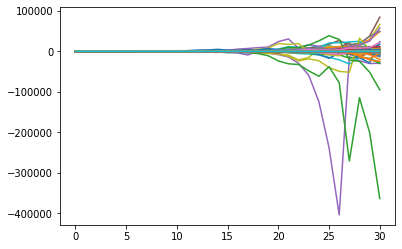

In [121]:
results = []
ax=plt.plot()

for i in range(10000): #running this 10,000 times... for science!(and statistical relevance)
    
    trial = single_trial()
    plt.plot(trial)
    results.append(trial[-1])
    
# plt.ylim(-800,800)
plt.show()

yay colors! so what we're looking at is the process of each trial evolving over time, and we eventually get a few trials that are WAY higher and a few that are WAY lower, but most of the trials end somewhere in between. In fact, these results have a normal distribution!

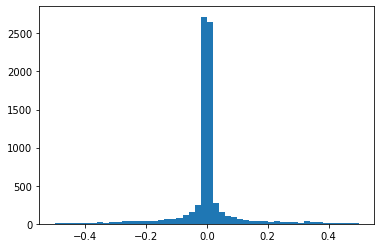

In [122]:
plt.hist(results, range=(-0.5,0.5), bins=50)
plt.show()

And getting into some descriptive analysis:

In [123]:
print(np.mean(results))

-20.025183417009323


In [124]:
np.percentile(results,5)

-5.548164294190449

In [125]:
np.percentile(results,95)

6.994463377898288

In [126]:
np.percentile(results,50)

-1.1461403561223869e-09